In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CS 663 Project


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CS 663 Project


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from pathlib import Path
import torch
import torch.nn as nn
from torchvision import models, transforms


In [ ]:


def apply_clahe(input_path, clip_limit=2.0, tile_grid_size=(8, 8)):

    input_path = str(input_path)
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not read image: {input_path}")
    clahe = cv2.createCLAHE(clipLimit=clip_limit,
                            tileGridSize=tile_grid_size)

    clahe_img = clahe.apply(img)
    return clahe_img

def enhancement_mmg(image, clahe_img, mv=3, T=10):
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image.copy()

    B = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated_image = cv2.dilate(gray_image, B)
    eroded_image = cv2.erode(gray_image, B)

    DmE = dilated_image - eroded_image
    enhanced_image = np.zeros_like(DmE, dtype=np.float32)

    for i in range(DmE.shape[0]):
        for j in range(DmE.shape[1]):
            if DmE[i, j] >= T:
                enhanced_image[i, j] = DmE[i, j] * mv

    alpha = 0.5
    enhanced_image = cv2.normalize(
        enhanced_image, None, 0, 255, cv2.NORM_MINMAX
    )
    enhanced_image = enhanced_image.astype(np.uint8)
    blended = cv2.addWeighted(clahe_img, alpha, enhanced_image, 1 - alpha, 0)

    return blended, enhanced_image, alpha


In [ ]:
example_path = "data_binary_classification/train/PNEUMONIA/person983_bacteria_2910.jpeg"
original_image = cv2.imread(example_path)
clahe_img = apply_clahe(example_path)
final_blend_img, edge_enhanced_img, alpha = enhancement_mmg(original_image,clahe_img, mv=4, T=15)

/tmp/ipython-input-3580034957.py:34: RuntimeWarning: overflow encountered in scalar multiply
  enhanced_image[i, j] = DmE[i, j] * mv


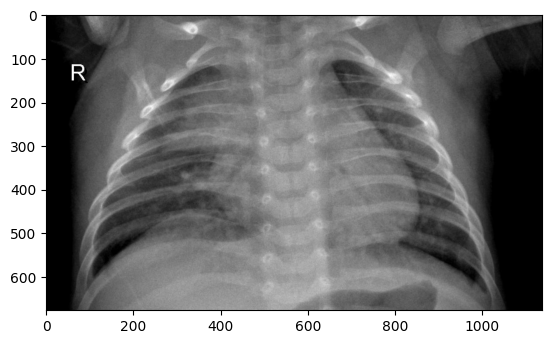

In [ ]:
plt.imshow(cv2.imread(example_path), cmap= 'grey')


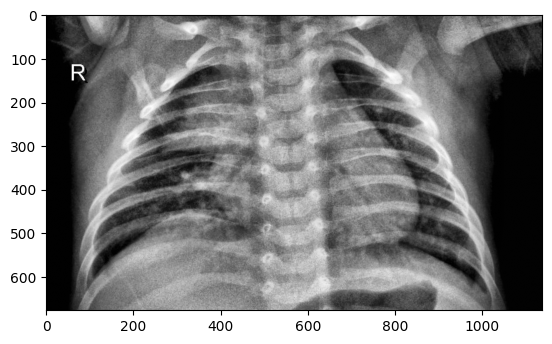

In [ ]:
plt.imshow(clahe_img, cmap= 'grey')

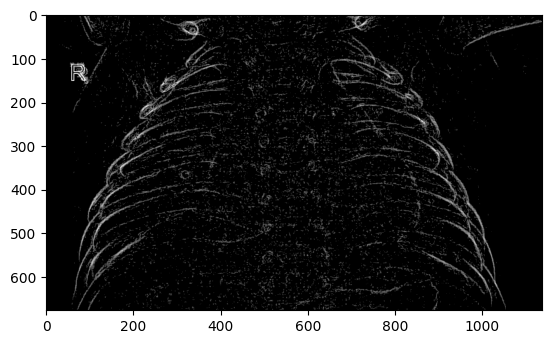

In [ ]:
plt.imshow(edge_enhanced_img, cmap= 'grey')

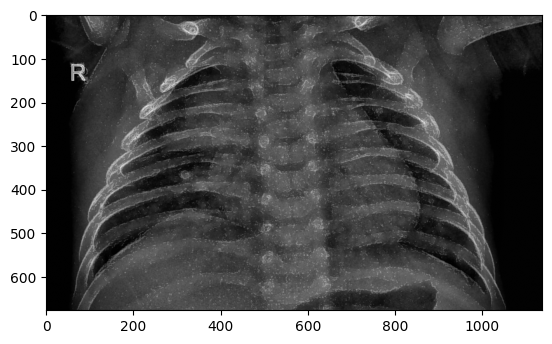

In [ ]:
plt.imshow(final_blend_img, cmap='grey')

In [ ]:
from tqdm import tqdm  # progress bar, optional
import os

def process_folder(src_dir, dst_dir, clip_limit=2.0, tile_grid_size=(8, 8), mv=1, T=30):
    src_dir = Path(src_dir)
    dst_dir = Path(dst_dir)
    dst_dir.mkdir(parents=True, exist_ok=True)

    exts = (".png", ".jpg", ".jpeg", ".JPG", ".JPEG", ".PNG")

    image_paths = [p for p in src_dir.iterdir() if p.suffix in exts]

    print(f"Processing {len(image_paths)} images from {src_dir} -> {dst_dir}")

    for img_path in tqdm(image_paths):
        try:
            img = cv2.imread(str(img_path))
            clahe_img = apply_clahe(img_path, clip_limit=clip_limit, tile_grid_size=tile_grid_size)
            final_blend_img, edge_enhanced_img, alpha = enhancement_mmg(img, clahe_img, mv=mv, T=T)
            out_path = dst_dir / img_path.name
            cv2.imwrite(str(out_path), final_blend_img)

        except Exception as e:
            print(f"Failed on {img_path}: {e}")


In [ ]:
base_dir = Path("data_binary_classification")

splits = ["train", "test"]
classes = ["NORMAL", "PNEUMONIA"]

for split in splits:
    for cls in classes:
        src = base_dir / split / cls
        dst = base_dir / split / f"{cls}_ENHANCED"

        print(f"\n=== {split.upper()} / {cls} ===")
        process_folder(
            src_dir=src,
            dst_dir=dst,
            clip_limit=2.0,
            tile_grid_size=(8, 8),
            mv=4,
            T=15,
        )



=== TRAIN / NORMAL ===
Processing 1341 images from data_binary_classification/train/NORMAL -> data_binary_classification/train/NORMAL_ENHANCED


  0%|          | 0/1341 [00:00<?, ?it/s]/tmp/ipython-input-3580034957.py:34: RuntimeWarning: overflow encountered in scalar multiply
  enhanced_image[i, j] = DmE[i, j] * mv
 27%|██▋       | 358/1341 [05:56<13:34,  1.21it/s]